
# Numba: compilation "Just in Time" (jit)

Numba convertit les fonctions Python en code machine optimisé au moment de l'exécution à l'aide de la bibliothèque de compilateur LLVM standard.
Les algorithmes numériques compilés par Numba en Python peuvent alors approcher les vitesses de C ou de FORTRAN, la où les boucles classiques, comme en R et matlab, peuvent être un peu lente.

https://numba.pydata.org/ see also https://numba.pydata.org/numba-doc/dev/user/jit.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import jit
import matplotlib.animation as animation
%matplotlib inline
from IPython.display import HTML

# Exemple 1: Méthode de Monte Carlo pour approcher $\pi$
See https://numba.pydata.org/numba-doc/dev/glossary.html#term-nopython-mode for why typing `nopython=True` below.

The underlying idea of this function is to approximate $\pi$ using a simple procedure:
generate points uniformly at random in the set $[0,1] \times [0,1]$. Keep only the points whose Euclidean norm is smaller than 1. The ratio of points in this area w.r.t. the total number of points is the ratio between the area of this region and the one of $[0,1] \times [0,1]$. It is is easy to check that this ratio is $\pi/4$

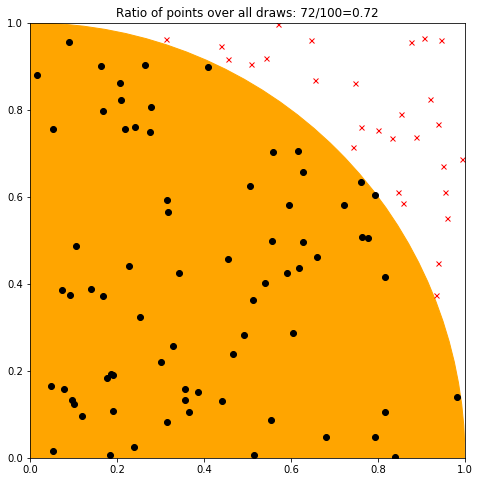

In [2]:
fig = plt.figure(figsize=(8,8))
circle1 = plt.Circle((0, 0), 1, color='orange')
ax = fig.gca()
ax.add_artist(circle1)
ax.set_aspect('equal')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
targeted = 0
n_samples = 101
lst = np.zeros(n_samples)
coordinates = []
for sample in range(1, n_samples):
    vec = np.random.rand(2)
    if np.linalg.norm(vec) < 1.:
        plt.plot(vec[0], vec[1], 'ok')
        targeted += 1
        lst[sample] = 1
    else:
        plt.plot(vec[0], vec[1], 'xr', markersize=5)
    coordinates.append(vec)
    ax.set_title('Ratio of points over all draws: {0}/{1}={2}'.format(targeted, sample, targeted/sample))
plt.show()

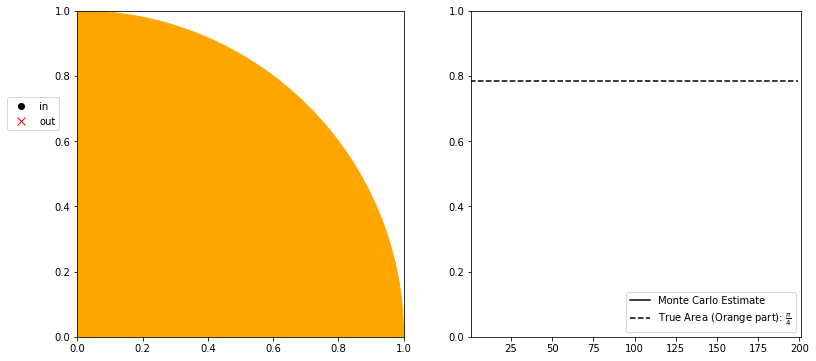

In [ ]:

targeted = 0
n_samples = 200
lst = np.zeros(n_samples)
vec = np.random.rand(2, n_samples)
current_ratio = np.zeros(n_samples)
for sample in range(n_samples):
    if np.linalg.norm(vec[:, sample]) < 1.:
        targeted += 1
        lst[sample] = 1
    current_ratio[sample] = targeted / (sample+1)

xdata_in, ydata_in = [], []
xdata_out, ydata_out = [], []
xconv, yconv = [], []
xpoint, ypoint = [], []

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(13, 6))

ln_in, = ax.plot([], [], 'ok', label='in')
ln_out, = ax.plot([], [], 'xr', markersize=8, label='out')
line_conv, = ax2.plot([], [], '-', color='k',
                      label='Monte Carlo Estimate')
point_conv, = ax2.plot([], [], 'o', color='k')

ax2.plot(np.arange(n_samples), np.full(
    (n_samples,), np.pi/4), '--k', label=r'True Area (Orange part): $\frac{\pi}{4}$')


def init():
    circle1 = plt.Circle((0, 0), 1, color='orange')
    ax.add_artist(circle1)
    ax.set_aspect('equal')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend(bbox_to_anchor=(-0.04, 0.75))

    ax2.set_xlim([1, n_samples + 1])
    ax2.set_ylim([0, 1])
    ax2.legend(loc=4)

    return ln_in, ln_out, line_conv, point_conv


def update(frame):
    if lst[frame] > 0.5:
        xdata_in.append(vec[0, frame])
        ydata_in.append(vec[1, frame])
        ln_in.set_data(xdata_in, ydata_in)
    else:
        xdata_out.append(vec[0, frame])
        ydata_out.append(vec[1, frame])
        ln_out.set_data(xdata_out, ydata_out)
    ax.set_title('Ratio of points over all draws: {0:0.2}'.format(
        current_ratio[frame]))
    ax2.set_title('Monte Carlo: convergence trough iterates')

    xconv.append(frame+1)
    yconv.append(current_ratio[frame])

    line_conv.set_data(xconv, yconv)
    point_conv.set_data(frame+1, current_ratio[frame])
    return ln_in, ln_out, line_conv, point_conv


ani = animation.FuncAnimation(fig, update, frames=n_samples, interval=150,
                              init_func=init, blit=True)
# plt.show()

In [ ]:
HTML(ani.to_html5_video())  # Need ffmpeg installed on your machine

In [ ]:
# Reminder: orange area is:
np.pi/4

In [ ]:
@jit(nopython=True) 
def monte_carlo_pi(n_samples=1000):
    acc = 0
    for sample in range(n_samples):
        vec = np.random.rand(2)
        if np.linalg.norm(vec) < 1.:
            acc += 1
    return 4.0 * acc / n_samples 

In [ ]:
# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
monte_carlo_pi(n_samples=10000000)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
monte_carlo_pi(n_samples=1000)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

# Exemple 2: fonction matricielle (sans utiliser numpy)

In [ ]:
def go_slow(a):  # Function is compiled and runs in machine code
    trace = 0
    for i in range(a.shape[0]):
        trace += a[i, i]
    return trace


all_n_samples = [1000, 5000, 10000]
t0 = []
t1 = []
t2 = []

for n_samples in all_n_samples:
    print(n_samples)
    x = np.arange(n_samples ** 2).reshape(n_samples, n_samples)

    @jit(nopython=True)
    def go_fast(a):  # Function is compiled and runs in machine code
        trace = 0
        for i in range(a.shape[0]):
            trace += a[i, i]
        return trace
    # COMPILATION INCLUSE!
    start = time.time()
    go_fast(x)
    end = time.time()
    t0.append(end - start)
    print("Elapsed (with compilation) = %s" % (end - start))
    # COMPILATION NON INCLUSE, EXECUTER DEPUIS LE CACHE
    start = time.time()
    go_fast(x)
    end = time.time()
    t1.append(end - start)
    print("Elapsed (after compilation) = %s" % (end - start))
    # VANILLA PYTHON
    start = time.time()
    go_slow(x)
    end = time.time()
    t2.append(end - start)
    print("Elapsed (vanilla) = %s" % (end - start))


t0 = np.array(t0)
t1 = np.array(t1)
t2 = np.array(t2)


print(all_n_samples)
print("Améliorations en pourcentage par rapport au code vanilla")
print((t0 - t2) / t2 * 100)
print((t1 - t2) / t2 * 100)

# Exemple 3: descente de gradient avec/sans numba.

In [ ]:
n_samples = 1000
n_features = 500
n_iterations = 2000

X = np.random.randn(n_samples, n_features)
y = np.random.randn(n_samples)
y[n_samples // 2:] = 0

w = np.zeros(n_features)  # init = 0

In [ ]:
@jit(nopython=True)
# Function is compiled and runs in machine code
def gradient(X, y, w, step_size=0.01,  max_iter=1000):
    """Gradient descent with constant step size."""
    for k in range(max_iter):
        w -=  step_size * (X.T.dot(X.dot(w) - y))
    return w

# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
gradient(X, y, w)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
gradient(X, y, w)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

# Exemple 4: Régression logistique

In [ ]:
y = np.random.randint(2, size=n_samples) *2 -1
print(y)
w = np.zeros(n_features)  # init = 0

In [ ]:
def logistic_regression_no_jit(y, X, w, iterations=1000):
    for i in range(iterations):
        w -= np.dot(((1.0 / (1.0 + np.exp(-y * np.dot(X, w))) - 1.0) * y), X)
    return w

In [ ]:
start = time.time()
logistic_regression_no_jit(y, X, w, iterations=n_iterations )
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))


In [ ]:
@jit(nopython=True)
def logistic_regression(y, X, w, iterations=1000):
    for i in range(iterations):
        w -= np.dot(((1.0 / (1.0 + np.exp(-y * np.dot(X, w))) - 1.0) * y), X)
    return w

In [ ]:
# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
logistic_regression(y, X, w, iterations=n_iterations)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
logistic_regression(y, X, w, iterations=n_iterations)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

### For  more on numba:

Parallelization: https://numba.pydata.org/numba-doc/dev/user/parallel.html